In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
import sys
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional

In [ ]:
def read_data():
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=False)

  Data_dir = '/content/gdrive/My Drive/Colab_Notebooks/Datasets/Pink Floyd/'
  data = pd.read_csv(Data_dir+ 'pink_floyd_lyrics.csv')
  wiki_data = pd.read_csv(Data_dir+ 'wiki_data_all_songs.csv')
  return data,wiki_data

df,wdf = read_data()
df.head()

Mounted at /content/gdrive


,album,song_title,year,lyrics
0,The Piper at the Gates of Dawn,Astronomy Domine,1967-08-05,"""Moon in both [houses]...""...Scorpio, [Arabian..."
1,The Piper at the Gates of Dawn,Lucifer Sam,1967-08-05,"Lucifer Sam, siam cat\nAlways sitting by your ..."
2,The Piper at the Gates of Dawn,Matilda Mother,1967-08-05,There was a king who ruled the land\nHis Majes...
3,The Piper at the Gates of Dawn,Flaming,1967-08-05,Alone in the clouds all blue\nLying on an eide...
4,The Piper at the Gates of Dawn,Pow R. Toc H.,1967-08-05,TCH TCH\nAHH (AHH)\nTCH TCH\nAHH AHH\nDoi doi\...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   album       163 non-null    object
 1   song_title  163 non-null    object
 2   year        163 non-null    object
 3   lyrics      125 non-null    object
dtypes: object(4)
memory usage: 5.2+ KB


## pink floyd lyrics generator

In [ ]:
wdf.year.max()-wdf.year.min()

52

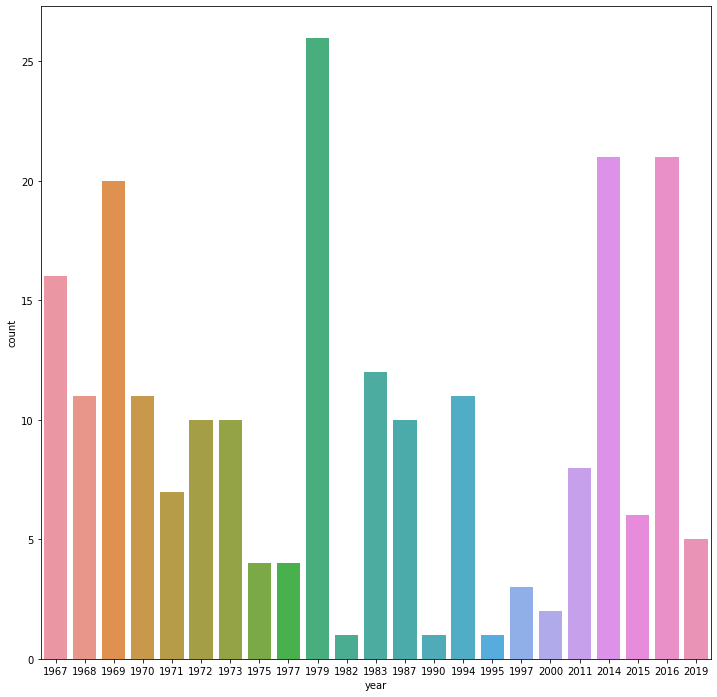

In [ ]:
plt.figure(figsize=(12,12),edgecolor='blue')
sns.countplot(x="year", data=wdf)

In [ ]:
def count_lines(text):
  count,k,p=0,0,0
  for i in text.split('\n'):
    res = re.findall("[a-zA-Z’]+", i)
    if res:
      p+=1
      if len(res)>2:
        k+=1
        count+=len(res)
  if k!=0:
    mean = count/k
  else:
    mean = 2
  total = p
  big_lines = k
  small_lines = (p-k)
  
  return mean,total,big_lines,small_lines

cl = []
for j in range(0,len(df)):
  if type(df.lyrics.iloc[j])==str :
    m,t,bl,sl = count_lines(df.lyrics.iloc[j])
    year = int(df.year.iloc[j].split('-')[0])
    if sl!=0:
      l = [m,t,bl,sl,bl/sl,year]
    else:
      l = [m,t,bl,sl,0,year]
    cl.append(l)

df_clines = pd.DataFrame(cl,columns=['mean_lines','total_lines','big_lines','small_lines','ratio_of_blsl','year'])
df_clines.head()

,mean_lines,total_lines,big_lines,small_lines,ratio_of_blsl,year
0,6.071429,15,14,1,14.000000,1967
1,5.571429,16,14,2,7.000000,1967
2,5.409091,28,22,6,3.666667,1967
3,4.600000,20,20,0,0.000000,1967
4,3.500000,10,2,8,0.250000,1967


Text(0.5, 1.0, 'Ratio of Big/small lines')

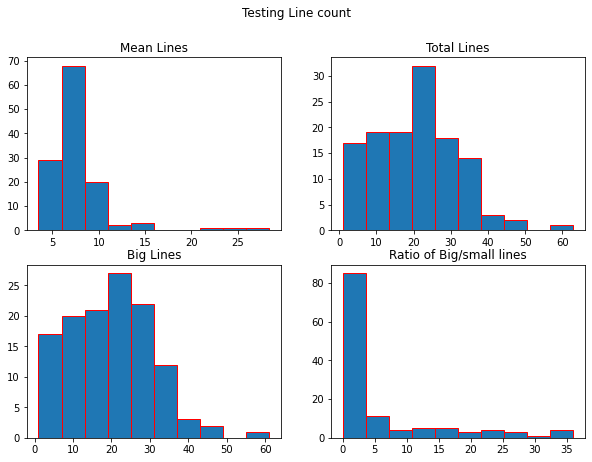

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(10,7))
fig.suptitle('Testing Line count')

axs[0,0].hist(df_clines['mean_lines'],edgecolor='red')
axs[0,0].set_title('Mean Lines')
axs[0,1].hist(df_clines['total_lines'],edgecolor='red')
axs[0,1].set_title('Total Lines')
axs[1,0].hist(df_clines['big_lines'],edgecolor='red')
axs[1,0].set_title('Big Lines')
axs[1,1].hist(df_clines['ratio_of_blsl'],edgecolor='red')
axs[1,1].set_title('Ratio of Big/small lines')

In [ ]:
df_clines_gb = df_clines.groupby(['year']).mean()
df_clines_gb.reset_index(level=0, inplace=True)
df_clines_gb

,year,mean_lines,total_lines,big_lines,small_lines,ratio_of_blsl
0,1967,5.841000,19.250000,16.416667,2.833333,4.245040
1,1968,6.713571,20.875000,19.875000,1.000000,9.025000
2,1969,8.027602,17.900000,17.400000,0.500000,2.950000
3,1970,7.256591,17.000000,16.800000,0.200000,4.400000
4,1971,7.973779,17.666667,16.833333,0.833333,0.566667
5,1972,6.400952,23.333333,22.166667,1.166667,0.333333
6,1973,8.667927,20.000000,19.111111,0.888889,5.277778
7,1975,6.807713,18.400000,18.200000,0.200000,5.200000
8,1977,7.662409,26.000000,25.600000,0.400000,3.700000
9,1979,7.294332,19.692308,17.461538,2.230769,5.256624


Text(0.5, 1.0, 'Ratio of Big/small lines')

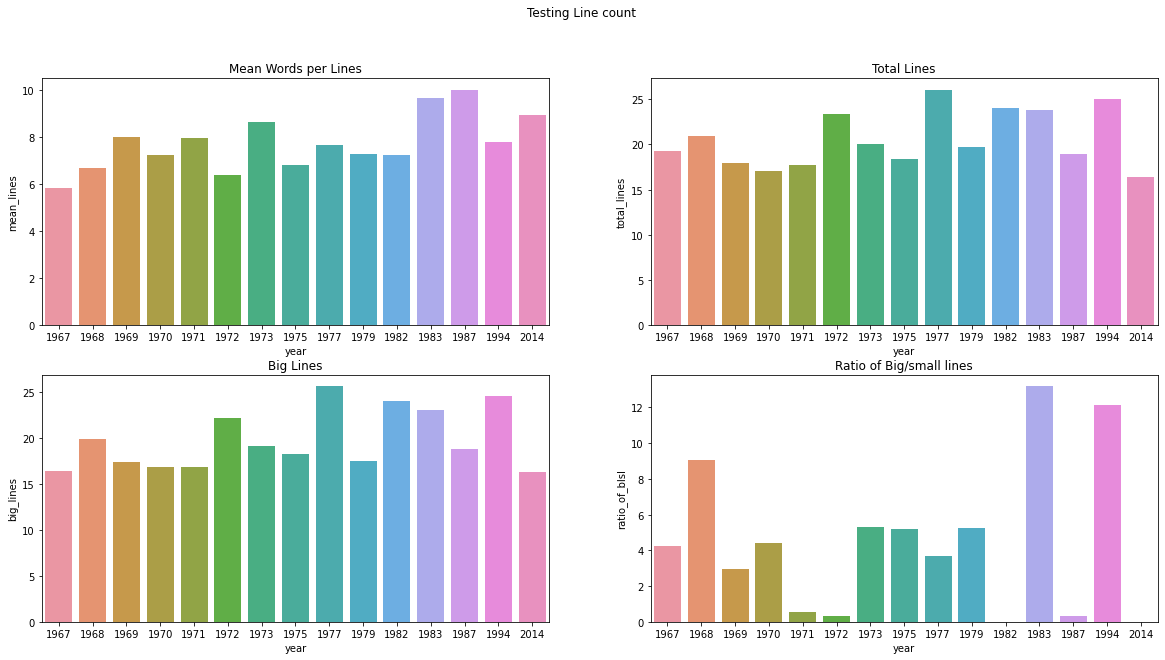

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,10))
fig.suptitle('Testing Line count')

sns.barplot(ax=axs[0,0],x="year",y='mean_lines', data=df_clines_gb)
axs[0,0].set_title('Mean Words per Lines')
sns.barplot(ax=axs[0,1],x="year",y='total_lines', data=df_clines_gb)
axs[0,1].set_title('Total Lines')
sns.barplot(ax=axs[1,0],x="year",y='big_lines', data=df_clines_gb)
axs[1,0].set_title('Big Lines')
sns.barplot(ax=axs[1,1],x="year",y='ratio_of_blsl', data=df_clines_gb)
axs[1,1].set_title('Ratio of Big/small lines')


In [ ]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t',char_level=False)
tokenizer.fit_on_texts([df.lyrics.iloc[1].replace('\n',' \n ')])
tokenizer.word_index

{'\n': 1,
 'a': 11,
 'always': 15,
 'anywhere': 36,
 'around': 18,
 'at': 37,
 'be': 13,
 'by': 16,
 'can’t': 7,
 'cat': 9,
 'cat’s': 4,
 'explain': 8,
 'found': 46,
 'gentle': 23,
 'go': 30,
 'ground': 44,
 'he’ll': 45,
 'he’s': 26,
 'hiding': 42,
 'hip': 33,
 'i': 6,
 'jennifer': 22,
 'left': 25,
 'lucifer': 14,
 'night': 38,
 'no': 29,
 'oh': 28,
 'on': 43,
 'prowling': 39,
 'right': 27,
 'sam': 19,
 'sand': 41,
 'sea': 32,
 'ship’s': 34,
 'siam': 20,
 'side': 2,
 'sifting': 40,
 'sitting': 21,
 'something': 5,
 'somewhere': 35,
 'that': 3,
 'the': 12,
 'to': 31,
 'when': 47,
 'witch': 24,
 'your': 17,
 'you’re': 10}

In [ ]:
lines=[]
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  print('--'*25)
  print(token_list)
  print('--'*25)

  for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        print(n_gram_sequence)

--------------------------------------------------
[]
--------------------------------------------------
--------------------------------------------------
[2, 3, 9, 4, 10]
--------------------------------------------------
[2, 3]
[2, 3, 9]
[2, 3, 9, 4]
[2, 3, 9, 4, 10]
--------------------------------------------------
[11, 5, 12, 1, 1]
--------------------------------------------------
[11, 5]
[11, 5, 12]
[11, 5, 12, 1]
[11, 5, 12, 1, 1]
--------------------------------------------------
[13, 14, 1, 1]
--------------------------------------------------
[13, 14]
[13, 14, 1]
[13, 14, 1, 1]
--------------------------------------------------
[15, 1, 1]
--------------------------------------------------
[15, 1]
[15, 1, 1]
--------------------------------------------------
[6, 5, 16, 1, 1]
--------------------------------------------------
[6, 5]
[6, 5, 16]
[6, 5, 16, 1]
[6, 5, 16, 1, 1]
--------------------------------------------------
[17, 2, 3, 18, 4, 6]
-------------------------------

In [ ]:
def ngram(token_list):
  ng = []
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    ng.append(n_gram_sequence)
  return ng

In [ ]:
df.iloc[[0]].lyrics.iloc[0]

'"Moon in both [houses]..."...Scorpio, [Arabian Skies], Libra..."...Pluto was not discovered until 1930..."\nLime and limpid green, a second scene\nA fight between the blue you once knew\nFloating down, the sound resounds\nAround the icy waters underground\nJupiter and Saturn, Oberon, Miranda and Titania\nNeptune, Titan, stars can frighten\n\nBlinding signs flap\nFlicker, flicker, flicker, blam\nPow, pow\nStairway scare Dan Dare who’s there?\n\nLime and limpid green, the sound surrounds\nThe icy waters under\nLime and limpid green, the sound surrounds\nThe icy waters underground'

In [ ]:
def seqform(data):
  
  tokenise = Tokenizer()
  input_sequences = []
  corpus = []
  k=0

  for i in range(0,len(df)):
    
   text = df.iloc[[i]].lyrics.iloc[0]
   if type(text)==float:
     pass
   else:
     text = text.lower().split("\n")
     text = [re.sub(r'\d+', '', i) for i in text]
     text = list(set(text))
     if text==' ':
       pass
     else:
       corpus.extend(text)
     k+=1
  
  tokenise.fit_on_texts(corpus)
  for line in corpus:
    token_list = tokenise.texts_to_sequences([line])[0]
    input_sequences.extend(ngram(token_list))
 
  
  max_sequence_len = max([len(x) for x in input_sequences])
  input_sequences = np.array(pad_sequences(input_sequences,
                       maxlen = max_sequence_len, padding='pre'))
  
  predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
  fin_data = pd.DataFrame(np.hstack((predictors, label.reshape(-1,1))),columns=np.hstack((np.arange(1,predictors.shape[1]+1),np.array(['label']))))
  total_words = len(tokenise.word_index) + 1
  print('{} number of lyrics inputted'.format(k))

  return fin_data,tokenise,max_sequence_len,total_words,predictors,label
  

In [ ]:
fdf,tokenise,max_sequence_len,total_words,predictors,label = seqform(df)
print(fdf.shape,max_sequence_len,total_words)

125 number of lyrics inputted
(13839, 88) 88 2983


In [ ]:
#Data_dir = '/content/gdrive/My Drive/Colab_Notebooks/Datasets/Pink Floyd/'
#fdf = pd.read_csv(Data_dir+'fin_df.csv')
fdf.head(10)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,356
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,356,296
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,356,296,512
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,216,6
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,216,6,357
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,216,6,357,833
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,216,6,357,833,834
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,216,6,357,833,834,835
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,216,6,357,833,834,835,297
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,216,6,357,833,834,835,297,836


In [ ]:
Data_dir = '/content/gdrive/My Drive/Colab_Notebooks/Datasets/Pink Floyd/'
fdf .to_csv(Data_dir+'fin_df.csv',index=False)
#fdf.head(5)

## LSTM

In [ ]:
'''Data_dir = '/content/gdrive/My Drive/Colab_Notebooks/Datasets/Pink Floyd/'
fdf = pd.read_csv(Data_dir+'fin_fdf.csv')'''
print(fdf.shape)
print(fdf.values.max())

(13839, 88)
2982


In [ ]:
dataX = [fdf.iloc[i,0:87].tolist() for i in range(0,fdf.shape[0])]
dataY = [fdf.iloc[i,87] for i in range(0,fdf.shape[0])]
print(len(dataX))
print(len(dataY))

13839
13839


In [ ]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (13839, 87, 1))

# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [ ]:
len(y[0])

2983

In [ ]:
print(predictors.shape)
print(label.shape)
print(X.shape,y.shape)
print(total_words,max_sequence_len)

(13839, 87)
(13839,)
(13839, 87, 1) (13839, 2983)
2983 88


In [ ]:
model = Sequential()
model.add(Embedding(total_words, 150, input_length=max_sequence_len-1))
# Add an LSTM Layer
model.add(Bidirectional(LSTM(150, return_sequences=True)))  
# A dropout layer for regularisation
model.add(Dropout(0.2))
# Add another LSTM Layer
model.add(LSTM(100)) 
model.add(Dense(total_words/2, activation='relu'))  
# In the last layer, the shape should be equal to the total number of words present in our corpus
model.add(Dense(y.shape[1], activation='softmax'))
#model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 87, 150)           447450    
_________________________________________________________________
bidirectional (Bidirectional (None, 87, 300)           361200    
_________________________________________________________________
dropout (Dropout)            (None, 87, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1491)              150591    
_________________________________________________________________
dense_1 (Dense)              (None, 2983)              4450636   
Total params: 5,570,277
Trainable params: 5,570,277
Non-trainable params: 0
______________________________________________

In [ ]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X,y, epochs= 60,callbacks=callbacks_list)
#model.fit(predictors, label, epochs=100, callbacks=callbacks_list)

Epoch 1/60
433/433 [==============================] - 227s 511ms/step - loss: 6.8269 - accuracy: 0.0582

Epoch 00001: loss improved from inf to 6.58436, saving model to weights-improvement-01-6.5844.hdf5
Epoch 2/60
433/433 [==============================] - 222s 513ms/step - loss: 6.0936 - accuracy: 0.0747

Epoch 00002: loss improved from 6.58436 to 6.10006, saving model to weights-improvement-02-6.1001.hdf5
Epoch 3/60
433/433 [==============================] - 220s 509ms/step - loss: 5.8963 - accuracy: 0.0743

Epoch 00003: loss improved from 6.10006 to 5.89432, saving model to weights-improvement-03-5.8943.hdf5
Epoch 4/60
433/433 [==============================] - 221s 509ms/step - loss: 5.6590 - accuracy: 0.0821

Epoch 00004: loss improved from 5.89432 to 5.64233, saving model to weights-improvement-04-5.6423.hdf5
Epoch 5/60
433/433 [==============================] - 224s 518ms/step - loss: 5.3759 - accuracy: 0.0984

Epoch 00005: loss improved from 5.64233 to 5.37447, saving model to

In [ ]:
#37-4.9734
filename = "weights-improvement-50-0.8289.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics='accuracy')
model.fit(X, y, epochs=20, callbacks=callbacks_list)

In [ ]:
model.save_weights(Data_dir+'my_model_weights.h5')
model.save(Data_dir+'my_model.h5')

In [ ]:
model.save(Data_dir + 'saved_model/my_model')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab_Notebooks/Datasets/Pink Floyd/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab_Notebooks/Datasets/Pink Floyd/saved_model/my_model/assets


In [ ]:
def make_lyrics(seed_text, next_words):
    pred_index=[]
    for i in range(next_words):
        token_list = tokenise.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],
                     maxlen=max_sequence_len-1,padding='pre')
        #print(token_list.shape)
        token_list = np.reshape(token_list, (1, max_sequence_len-1, 1))
        predicted = model.predict(token_list, verbose=0)
        predicted_index =  np.argmax(predicted)
        pred_index.append(predicted_index)
        


        #predicted_index=1
        output_word = ""
        for word, index in tokenise.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)
    return seed_text

In [ ]:
reverse_word_map = dict(map(reversed, tokenise.word_index.items()))
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
pattern_val = [i for i in pattern if i>0]
print("Seed:")
print(' '.join([reverse_word_map.get(value) for value in pattern_val]))
seed_text = [reverse_word_map.get(value)+' ' for value in pattern_val]

Seed:
blow


In [ ]:
line1 = make_lyrics('Do you',5)

Do you ever get tired of being


In [ ]:
line2 = make_lyrics('Cold heart',6)

Cold heart that way you can hear me


In [ ]:
line3 = make_lyrics('I am a machine',8)

I am a machine spoon in a while by a country stile


In [ ]:
line4 = make_lyrics('Kill me',8)

Kill me leaf and all the rain away rolled soon


In [ ]:
line5 = make_lyrics('Why god',5)

Why god torn in all directions now


In [ ]:
import pickle

# saving
with open(Data_dir+'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenise, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)